# LFW

Test Naive Bayes, Support Vector Machine, and Neural Networks for face classification. 

In [58]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

In [59]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [213]:
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

print(', '.join(target_names))

Total dataset size:
n_samples: 1560
n_features: 1850
n_classes: 12
Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Jacques Chirac, Jean Chretien, John Ashcroft, Junichiro Koizumi, Serena Williams, Tony Blair


In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [62]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 1170 faces
done in 0.291s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.054s


In [71]:
# #############################################################################
# helper class to do random parameter search for a given classifier and evaluate
# the final results

def search_and_evaluate(clf, param, X_train_pca, y_train, X_test_pca, X_test, y_test, n_iter=10): 
    print("Fitting the classifier to the training set")
    t0 = time()

    clf = RandomizedSearchCV(clf, param, cv=5, iid=False, n_iter=n_iter)
    clf = clf.fit(X_train_pca, y_train)

    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by random search:")
    print(clf.best_estimator_)
    
    print("Predicting people's names on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

    prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

    plot_gallery(X_test, prediction_titles, h, w)
    plt.show()
    
    # y_pred = clf.decision_function(X_test_pca)
    y_test_mAP = label_binarize(y_test, classes=list(range(12)))
    y_pred_mAP = label_binarize(y_pred, classes=list(range(12)))
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_mAP[:, i],
                                                            y_pred_mAP[:, i])
        average_precision[i] = average_precision_score(y_test_mAP[:, i], y_pred_mAP[:, i])
    
    mAP = 0 

    for i in range(n_classes): 
        mAP += average_precision[i]

    mAP /= n_classes 

    print('mAP: {}'.format(mAP))
    
    return clf

Fitting the classifier to the training set
done in 85.413s
Best estimator found by random search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.103s
                   precision    recall  f1-score   support

     Ariel Sharon       0.92      0.69      0.79        16
     Colin Powell       0.73      0.91      0.81        66
  Donald Rumsfeld       0.87      0.74      0.80        27
    George W Bush       0.82      0.94      0.88       140
Gerhard Schroeder       0.89      0.71      0.79        24
      Hugo Chavez       1.00      0.65      0.79        17
   Jacques Chirac       1.00      0.40      0.57        10
    Jean Chretien       1.00      0.79      0.88        14
    John Ashcroft       1.00      0.75      0.86        16
Junichiro Koizu

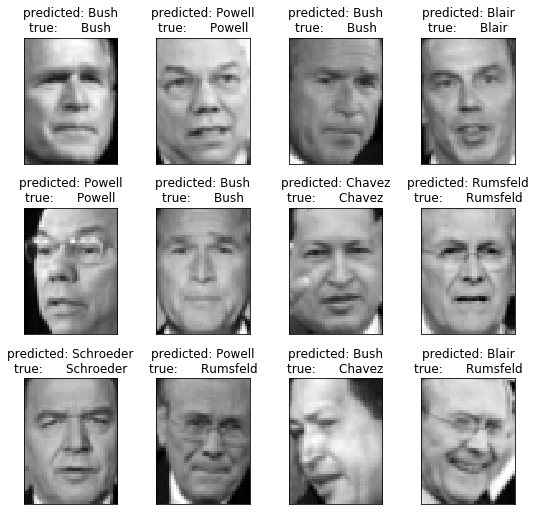

mAP: 0.6873442597635684


In [80]:
# #############################################################################
# Train a SVM classification model
svm = SVC(kernel='rbf', class_weight='balanced')

param = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 
              'degree': [3, 4, 5]}

svm = search_and_evaluate(svm, param, X_train_pca, y_train, X_test_pca, X_test, y_test, n_iter=40)

Fitting the classifier to the training set
done in 0.073s
Best estimator found by random search:
GaussianNB(priors=None, var_smoothing=1e-09)
Predicting people's names on the test set
done in 0.008s
                   precision    recall  f1-score   support

     Ariel Sharon       0.36      0.50      0.42        16
     Colin Powell       0.83      0.73      0.77        66
  Donald Rumsfeld       0.82      0.52      0.64        27
    George W Bush       0.67      0.77      0.72       140
Gerhard Schroeder       0.53      0.42      0.47        24
      Hugo Chavez       0.80      0.47      0.59        17
   Jacques Chirac       0.22      0.20      0.21        10
    Jean Chretien       0.54      0.50      0.52        14
    John Ashcroft       0.83      0.62      0.71        16
Junichiro Koizumi       0.88      0.64      0.74        11
  Serena Williams       0.21      0.56      0.30         9
       Tony Blair       0.78      0.72      0.75        40

         accuracy               

/home/tk/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


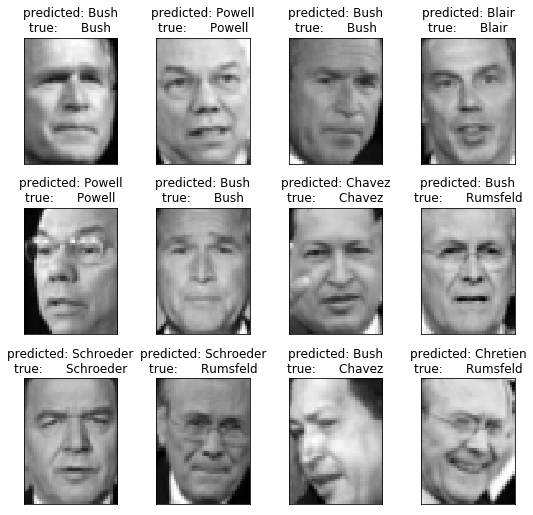

mAP: 0.39523863632066947


In [76]:
# #############################################################################
# Train a Naive Bayes classification model
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

param = {}

nb = search_and_evaluate(nb, param, X_train_pca, y_train, X_test_pca, X_test, y_test, n_iter=10)

Fitting the classifier to the training set


/home/tk/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tk/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tk/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/tk/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % sel

done in 439.440s
Best estimator found by random search:
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.0001, max_iter=2000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
Predicting people's names on the test set
done in 0.003s
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.69      0.69        16
     Colin Powell       0.84      0.88      0.86        66
  Donald Rumsfeld       0.67      0.67      0.67        27
    George W Bush       0.86      0.90      0.88       140
Gerhard Schroeder       0.65      0.62      0.64        24
      Hugo Chavez       0.77      0.

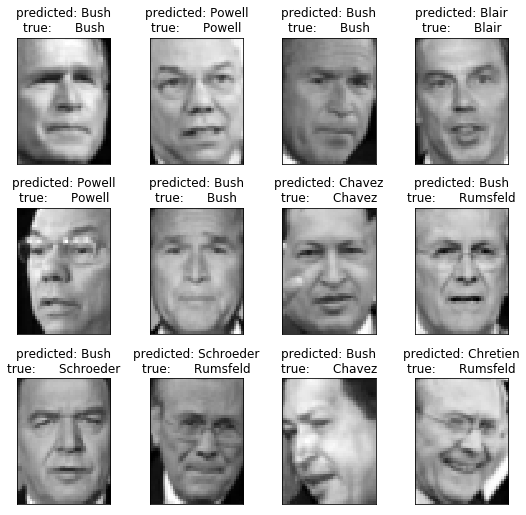

mAP: 0.5593169478717054


In [90]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

param = {'hidden_layer_sizes': [(100), (100,100), (200), (200,200)],
        'activation': ['relu'],
        'solver': ['adam'],
         'max_iter': [2000],
        'learning_rate_init': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

mlp = search_and_evaluate(mlp, param, X_train_pca, y_train, X_test_pca, X_test, y_test, n_iter=5)

In [131]:
def mAP(y_pred, y_true): 
    y_test_mAP = label_binarize(y_true, classes=list(range(12)))
    y_pred_mAP = label_binarize(y_pred, classes=list(range(12)))
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_mAP[:, i],
                                                            y_pred_mAP[:, i])
        average_precision[i] = average_precision_score(y_test_mAP[:, i], y_pred_mAP[:, i])
    
    mAP = 0 

    for i in range(n_classes): 
        mAP += average_precision[i]

    mAP /= 12

    return mAP

In [139]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import make_scorer

scorer = make_scorer(mAP, greater_is_better=True)

kfold = RepeatedKFold(n_splits=5, n_repeats=10)

In [140]:
print(X_test_pca.shape)

(390, 150)


In [150]:
num_test_samples = 100

y_pred = svm.predict(X_test_pca[:num_test_samples,:])

mAP(y_pred, y_test[:num_test_samples])

0.7421003251874464

In [151]:
# get mAP for SVM using k-fold cross validation

t0 = time()
svm_scores = cross_val_score(svm, X_train_pca, y_train, cv=kfold, n_jobs=-1, scoring=scorer)
print("done in %0.3fs" % (time() - t0))


done in 268.466s


In [152]:
print(svm_scores)

[0.57770342 0.61115323 0.58017267 0.61390294 0.53013562 0.51788205
 0.62792037 0.55945947 0.47085592 0.54765479 0.67842634 0.55020055
 0.56139061 0.56903906 0.52394046 0.49951948 0.56709572 0.61809675
 0.55640717 0.57864876 0.61813853 0.53069159 0.57929045 0.49643062
 0.61495134 0.55603746 0.56145424 0.50015586 0.60942196        nan
        nan 0.58932864 0.56395526 0.52932504 0.56215818 0.56089798
 0.54787874 0.67369768 0.57551727 0.51881966 0.54583923 0.59820293
 0.596418   0.56549047 0.48888461 0.52125505 0.59548191 0.51375295
 0.53252612 0.51381209]


In [153]:
# get mAP for NaiveBayes using k-fold cross validation

t0 = time()
nb_scores = cross_val_score(nb, X_train_pca, y_train, cv=kfold, n_jobs=-1, scoring=scorer)
print("done in %0.3fs" % (time() - t0))
print(nb_scores)

done in 1.684s
[0.32466855        nan 0.38269966 0.35224235 0.4348096  0.41996006
 0.36013271 0.3987891  0.34855073 0.44213187 0.41197406 0.4351686
 0.38124233        nan 0.39789302 0.37906964 0.32529027 0.44734097
 0.37379103 0.45189778 0.37017988 0.35664748 0.39325731 0.37138267
 0.45103755 0.40424247 0.3671941         nan 0.39115427 0.4014973
 0.48142454 0.40709409 0.36543259 0.38932965 0.35027532 0.36801893
 0.38280899 0.37237993 0.33360966 0.45762113 0.40262721 0.31711111
 0.44846866 0.34885417 0.35671914 0.45627113 0.4143678  0.40668889
 0.31329437 0.36156042]


In [180]:
# get mAP for Neural Network using k-fold cross validation

print(mlp.best_estimator_)

t0 = time()
mlp_scores = cross_val_score(mlp.best_estimator_, X_train_pca, y_train, cv=kfold, n_jobs=-1, scoring=scorer)
print("done in %0.3fs" % (time() - t0))
print(mlp_scores)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=200, learning_rate='constant',
              learning_rate_init=0.0001, max_iter=2000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
done in 935.301s
[0.52751795 0.48933835 0.51168672 0.47219787 0.60306993 0.54119211
 0.46528741 0.50199434 0.48990528 0.52577217 0.42576123 0.56908059
 0.48834508 0.56369671 0.50227419 0.52163344 0.48041496 0.52126659
 0.42425689 0.57988893 0.49912344 0.53785512 0.5806956  0.50280167
 0.5260506  0.43471567 0.45216849 0.53397287 0.51831316 0.4888988
 0.524709   0.58591743 0.48887771 0.50542022 0.38966269 0.49514044
 0.54148333 0.54605905 0.50269538 0.38502396 0.52619391 0.49163217
 0.49813204 0.45800

In [181]:
np.save('mlp_scores.npy', mlp_scores)

In [186]:
# compute paired t-testing
from scipy.stats import ttest_rel

In [188]:
mlp_scores = np.load('mlp_scores.npy') 
svm_scores = np.load('svm_scores.npy')
nb_scores = np.load('nb_scores.npy')

nans = np.logical_or(np.isnan(nb_scores), np.isnan(svm_scores))
nans = np.logical_or(nans, np.isnan(mlp_scores))
del_indices = np.nonzero(nans)

nb_scores = np.delete(nb_scores, del_indices)
svm_scores = np.delete(svm_scores, del_indices)
mlp_scores = np.delete(mlp_scores, del_indices)


# now do t-testing between NB and SVM
print('variance of nb %0.5f'% np.var(nb_scores))
print('variance of svm %0.5f'% np.var(svm_scores))
print('variance of nn %0.5f'% np.var(mlp_scores))


t_stat, p_val = ttest_rel(svm_scores, nb_scores)
print('SVM, NB: t-statistic: {}, p-value: {}'.format(t_stat, p_val))

t_stat, p_val = ttest_rel(svm_scores, mlp_scores)
print('SVM, NN: t-statistic: {}, p-value: {}'.format(t_stat, p_val))

t_stat, p_val = ttest_rel(nb_scores, mlp_scores)
print('NB, NN: t-statistic: {}, p-value: {}'.format(t_stat, p_val))

variance of nb 0.00154
variance of svm 0.00196
variance of nn 0.00237
SVM, NB: t-statistic: 20.109469824023005, p-value: 8.29210234697971e-24
SVM, NN: t-statistic: 6.00511902686991, p-value: 3.3167324492517356e-07
NB, NN: t-statistic: -13.411934966962216, p-value: 3.7896928223110546e-17


In [189]:
# plot histograms for each distribution
from matplotlib import pyplot as plt

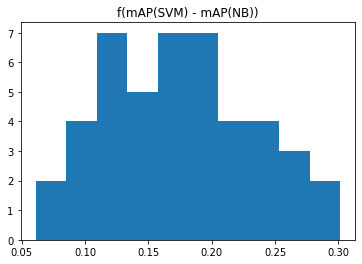

In [207]:
svm_nb_diff = svm_scores - nb_scores

hist, bins = np.histogram(svm_nb_diff, bins=10)

plt.hist(svm_nb_diff, bins=bins)
plt.title('f(mAP(SVM) - mAP(NB))')
plt.show()

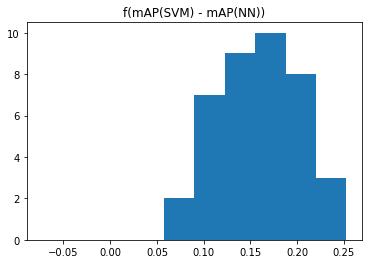

In [208]:
svm_mlp_diff = svm_scores - mlp_scores

hist, bins = np.histogram(svm_mlp_diff, bins=10)

plt.hist(svm_nb_diff, bins=bins)
plt.title('f(mAP(SVM) - mAP(NN))')
plt.show()

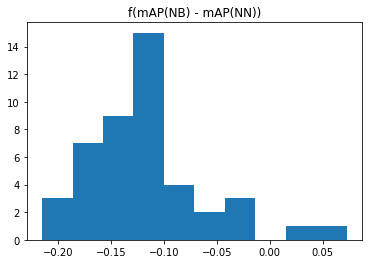

In [209]:
nb_mlp_diff = nb_scores - mlp_scores

hist, bins = np.histogram(nb_mlp_diff, bins=10)

plt.hist(nb_mlp_diff, bins=bins)
plt.title('f(mAP(NB) - mAP(NN))')
plt.show()